In [1]:
import numpy as np
import random
from skimage import io
from skimage.transform import resize
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

import torch
import torch.nn as nn
from copy import deepcopy
from utils.utils import scores_to_permutations, permutations_to_polygons

import json
import time
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from models.matching import OptimalMatching
from models.backbone import R2U_Net, NonMaxSuppression, DetectionBranch

from utils.dataloader_crowdai import CrowdAI
from pycocotools.coco import COCO

import matplotlib.pyplot as plt

import pandas as pd

import geopandas as gpd
from shapely.geometry import Polygon
from rasterio import features

import cv2
from PIL import Image

import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [2]:
class CrowdAI(Dataset):
    """CrowdAI dataset"""

    def __init__(self, images_directory, annotations_path):

        self.IMAGES_DIRECTORY = images_directory
        self.ANNOTATIONS_PATH = annotations_path
        
        self.window_size = 320
        self.max_points = 256

        # load annotation json
        with open(self.ANNOTATIONS_PATH) as f:
            self.annotations = json.load(f)
        
        self.images = pd.DataFrame(self.annotations['images'])[:100]
        self.labels = pd.DataFrame(self.annotations['annotations'])








    def _create_permutation_matrix(self, segmentations, N=256):

        permutation_matrix = torch.zeros((N, N), dtype=torch.uint8)

        n = 0
        for i, polygon in enumerate(segmentations):
            for v, point in enumerate(polygon):
                if v != len(polygon) - 1:
                    permutation_matrix[n, n+1] = 1
                else:
                    permutation_matrix[n, n-v] = 1
                n += 1

        return permutation_matrix
        


    def _create_segmentation_mask(self, polygons, image_size):
        mask = np.zeros((image_size, image_size), dtype=np.uint8)
        for polygon in polygons:
            cv2.fillPoly(mask, [polygon], 1)
        return torch.tensor(mask, dtype=torch.uint8)



    def _create_vertex_mask(self, polygons, image_shape=(320, 320)):
        mask = torch.zeros(image_shape, dtype=torch.uint8)
        for poly in polygons:
            for p in poly:
                mask[p[1], p[0]] = 1
        return mask








    def __len__(self):
        return len(self.images)







    def __getitem__(self, idx):

        image = io.imread(self.IMAGES_DIRECTORY + self.images['file_name'][idx])
        image = resize(image, (self.window_size, self.window_size), anti_aliasing=True)
        width, height = self.images['width'][idx], self.images['height'][idx]
        ratio = self.window_size / max(width, height)



        # Get the image ID
        image_id = self.images['id'][idx]
        # Get all annotations for this image
        image_annotations = self.labels[self.labels['image_id'] == image_id]
        # get all polygons for the image
        segmentations = image_annotations['segmentation'].values
        segmentations = [e[0] for e in segmentations]
        for i, poly in enumerate(segmentations):
            # rescale the polygon
            poly = [int(e * ratio) for e in poly]
            # out of bounds check
            for j, e in enumerate(poly):
                if j % 2 == 0:
                    poly[j] = min(max(0, e), self.window_size - 1)
                else:
                    poly[j] = min(max(0, e), self.window_size - 1)
            segmentations[i] = poly



        # print(segmentations)
        segmentations = [np.array(poly, dtype=int).reshape(-1, 2) for poly in segmentations] # convert a list of polygons to a list of numpy arrays of points
        # print(segmentations)





        # create permutation matrix
        permutation_matrix = self._create_permutation_matrix(segmentations, N=self.max_points)
        # create vertex mask
        vertex_mask = self._create_vertex_mask(segmentations, image_shape=(self.window_size, self.window_size))
        # create segmentation mask
        seg_mask = self._create_segmentation_mask(segmentations, image_size=self.window_size)
        # print(torch.topk(torch.tensor(vertex_mask.flatten()), self.max_points))





        return image, vertex_mask, seg_mask, permutation_matrix

In [3]:
# Initiate the dataloader
batch_size = 4
dataset = CrowdAI(images_directory='data/val/images/', annotations_path='data/val/annotation.json')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

In [4]:
image, vertex_mask, seg_mask, permutation_matrix = next(iter(dataloader))

In [5]:
image.shape, vertex_mask.shape, seg_mask.shape, permutation_matrix.shape

(torch.Size([4, 320, 320, 3]),
 torch.Size([4, 320, 320]),
 torch.Size([4, 320, 320]),
 torch.Size([4, 256, 256]))

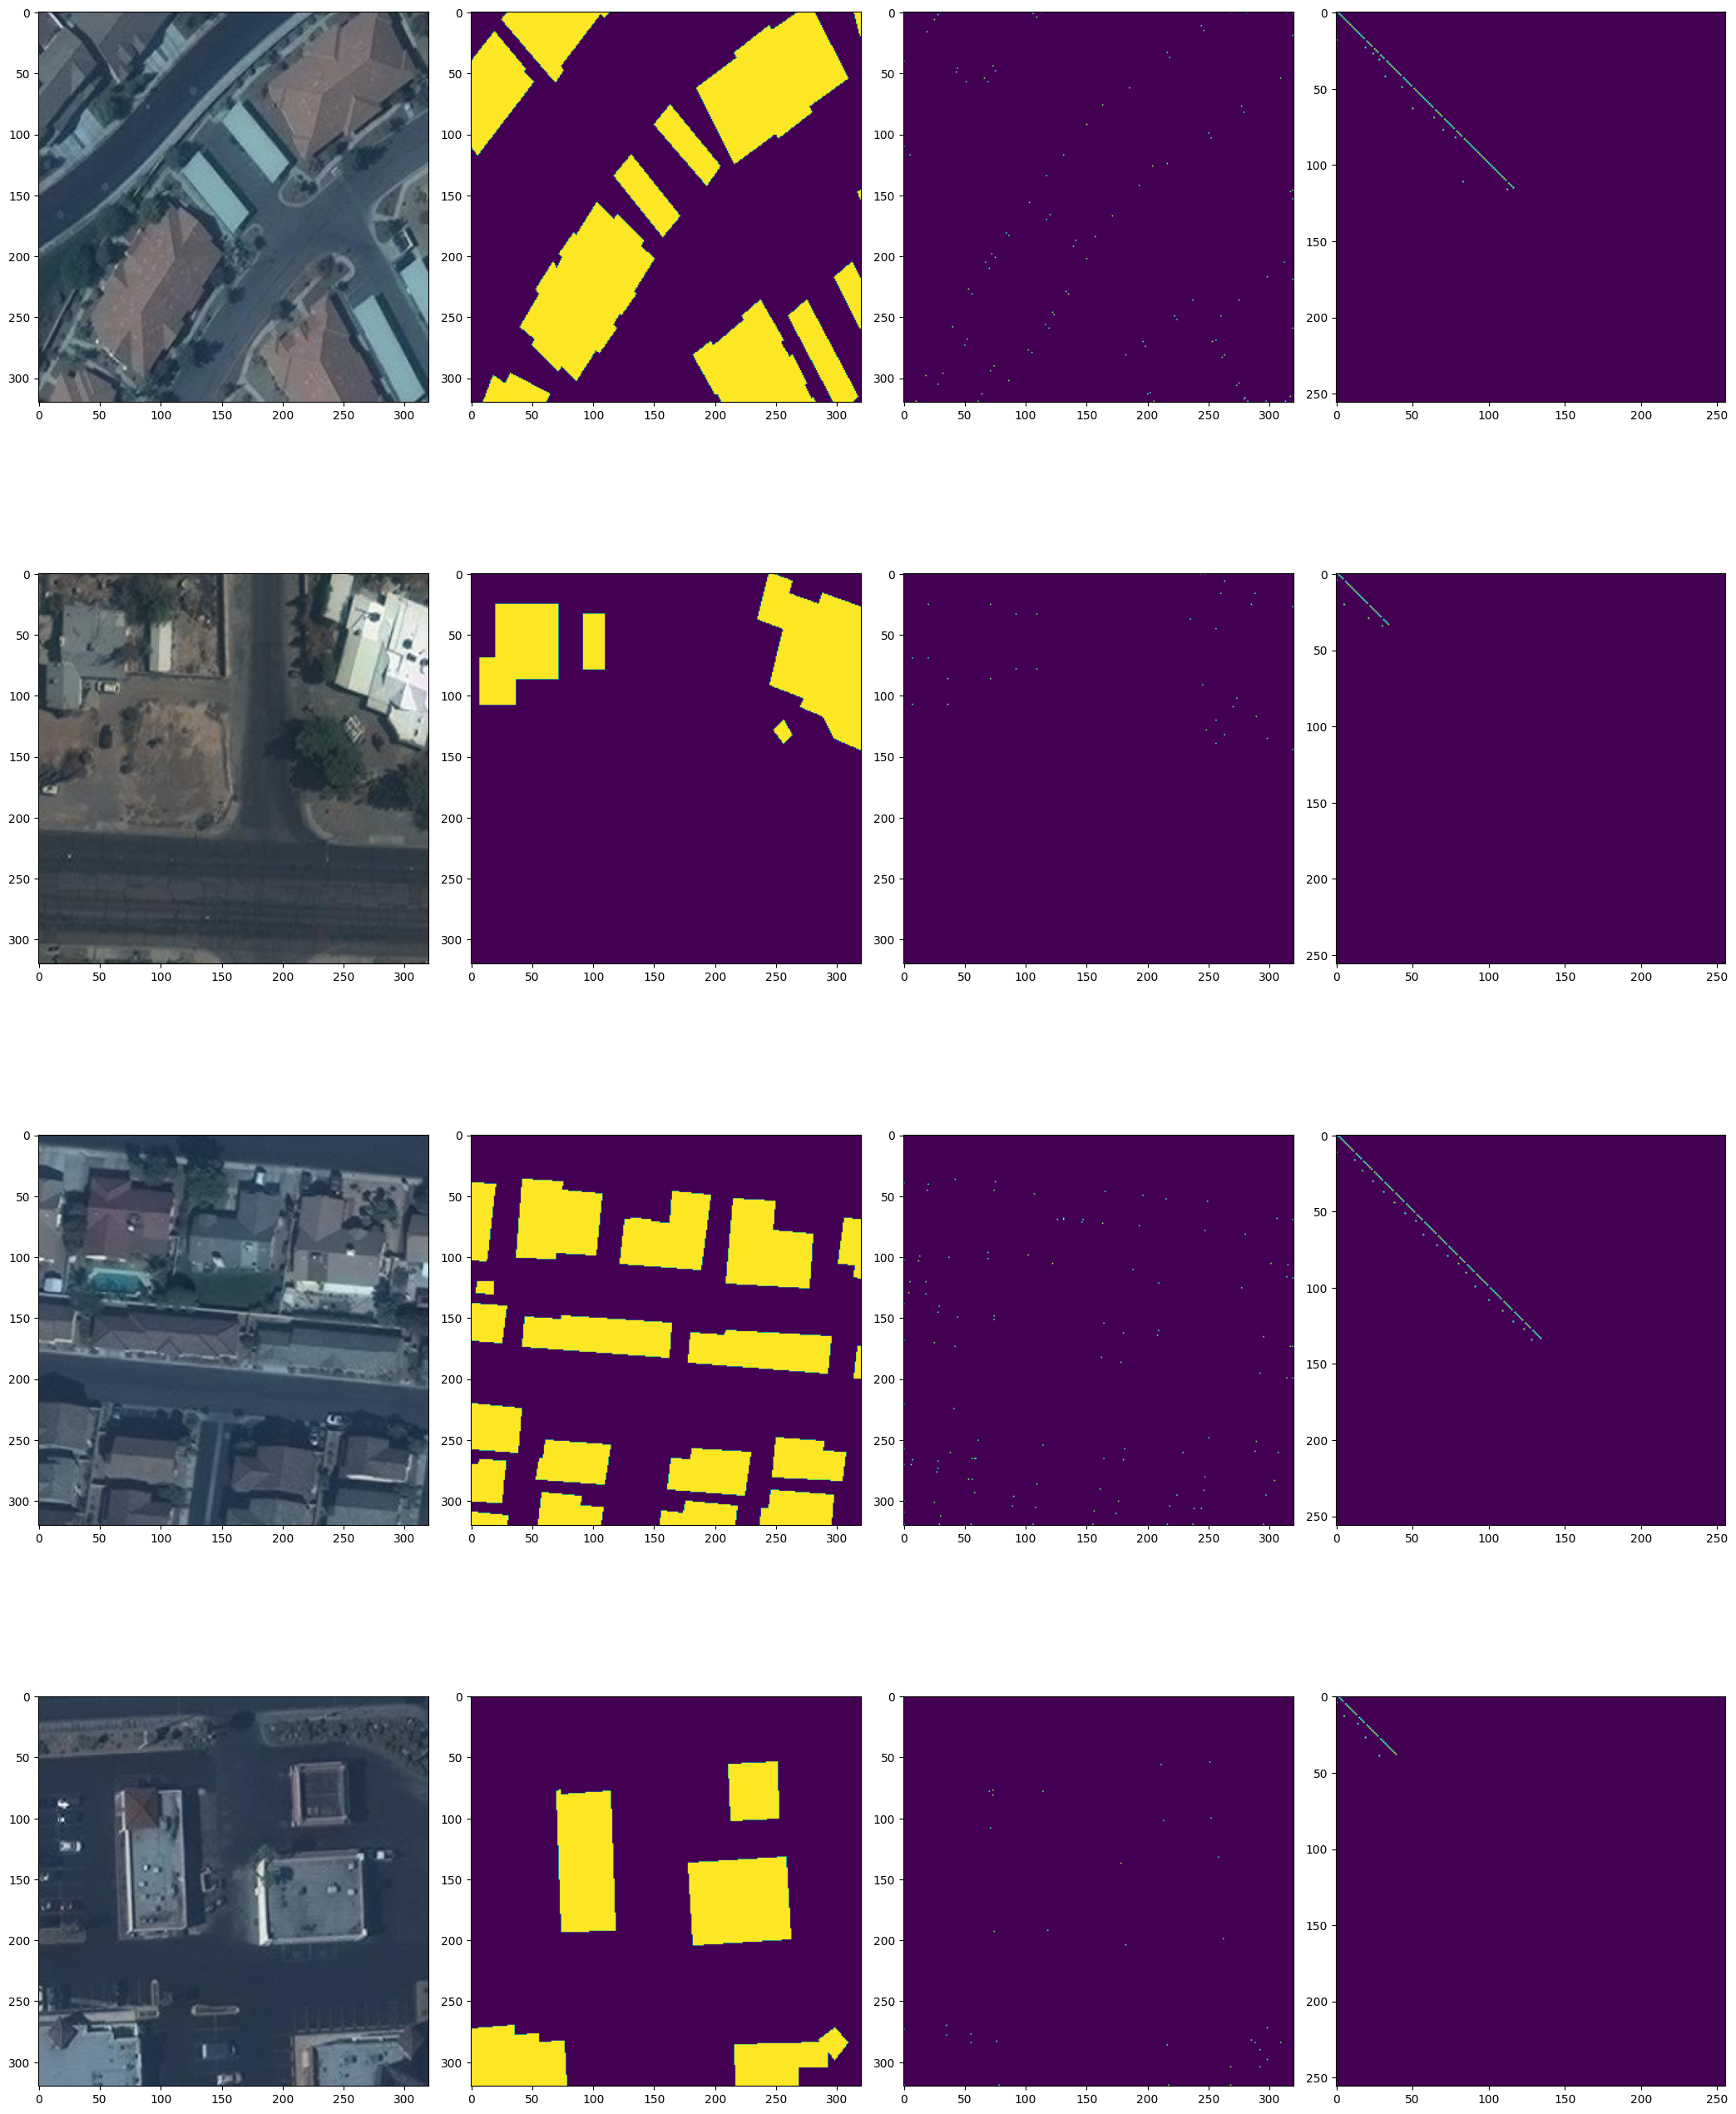

In [6]:
# plot all the masks and the images in the batch
fig, axes = plt.subplots(image.shape[0], 4, figsize=(21, 7*image.shape[0]))
for i in range(image.shape[0]):
    axes[i, 0].imshow(image[i])
    axes[i, 1].imshow(seg_mask[i])
    axes[i, 2].imshow(vertex_mask[i])
    axes[i, 3].imshow(permutation_matrix[i])
plt.tight_layout()
plt.show()

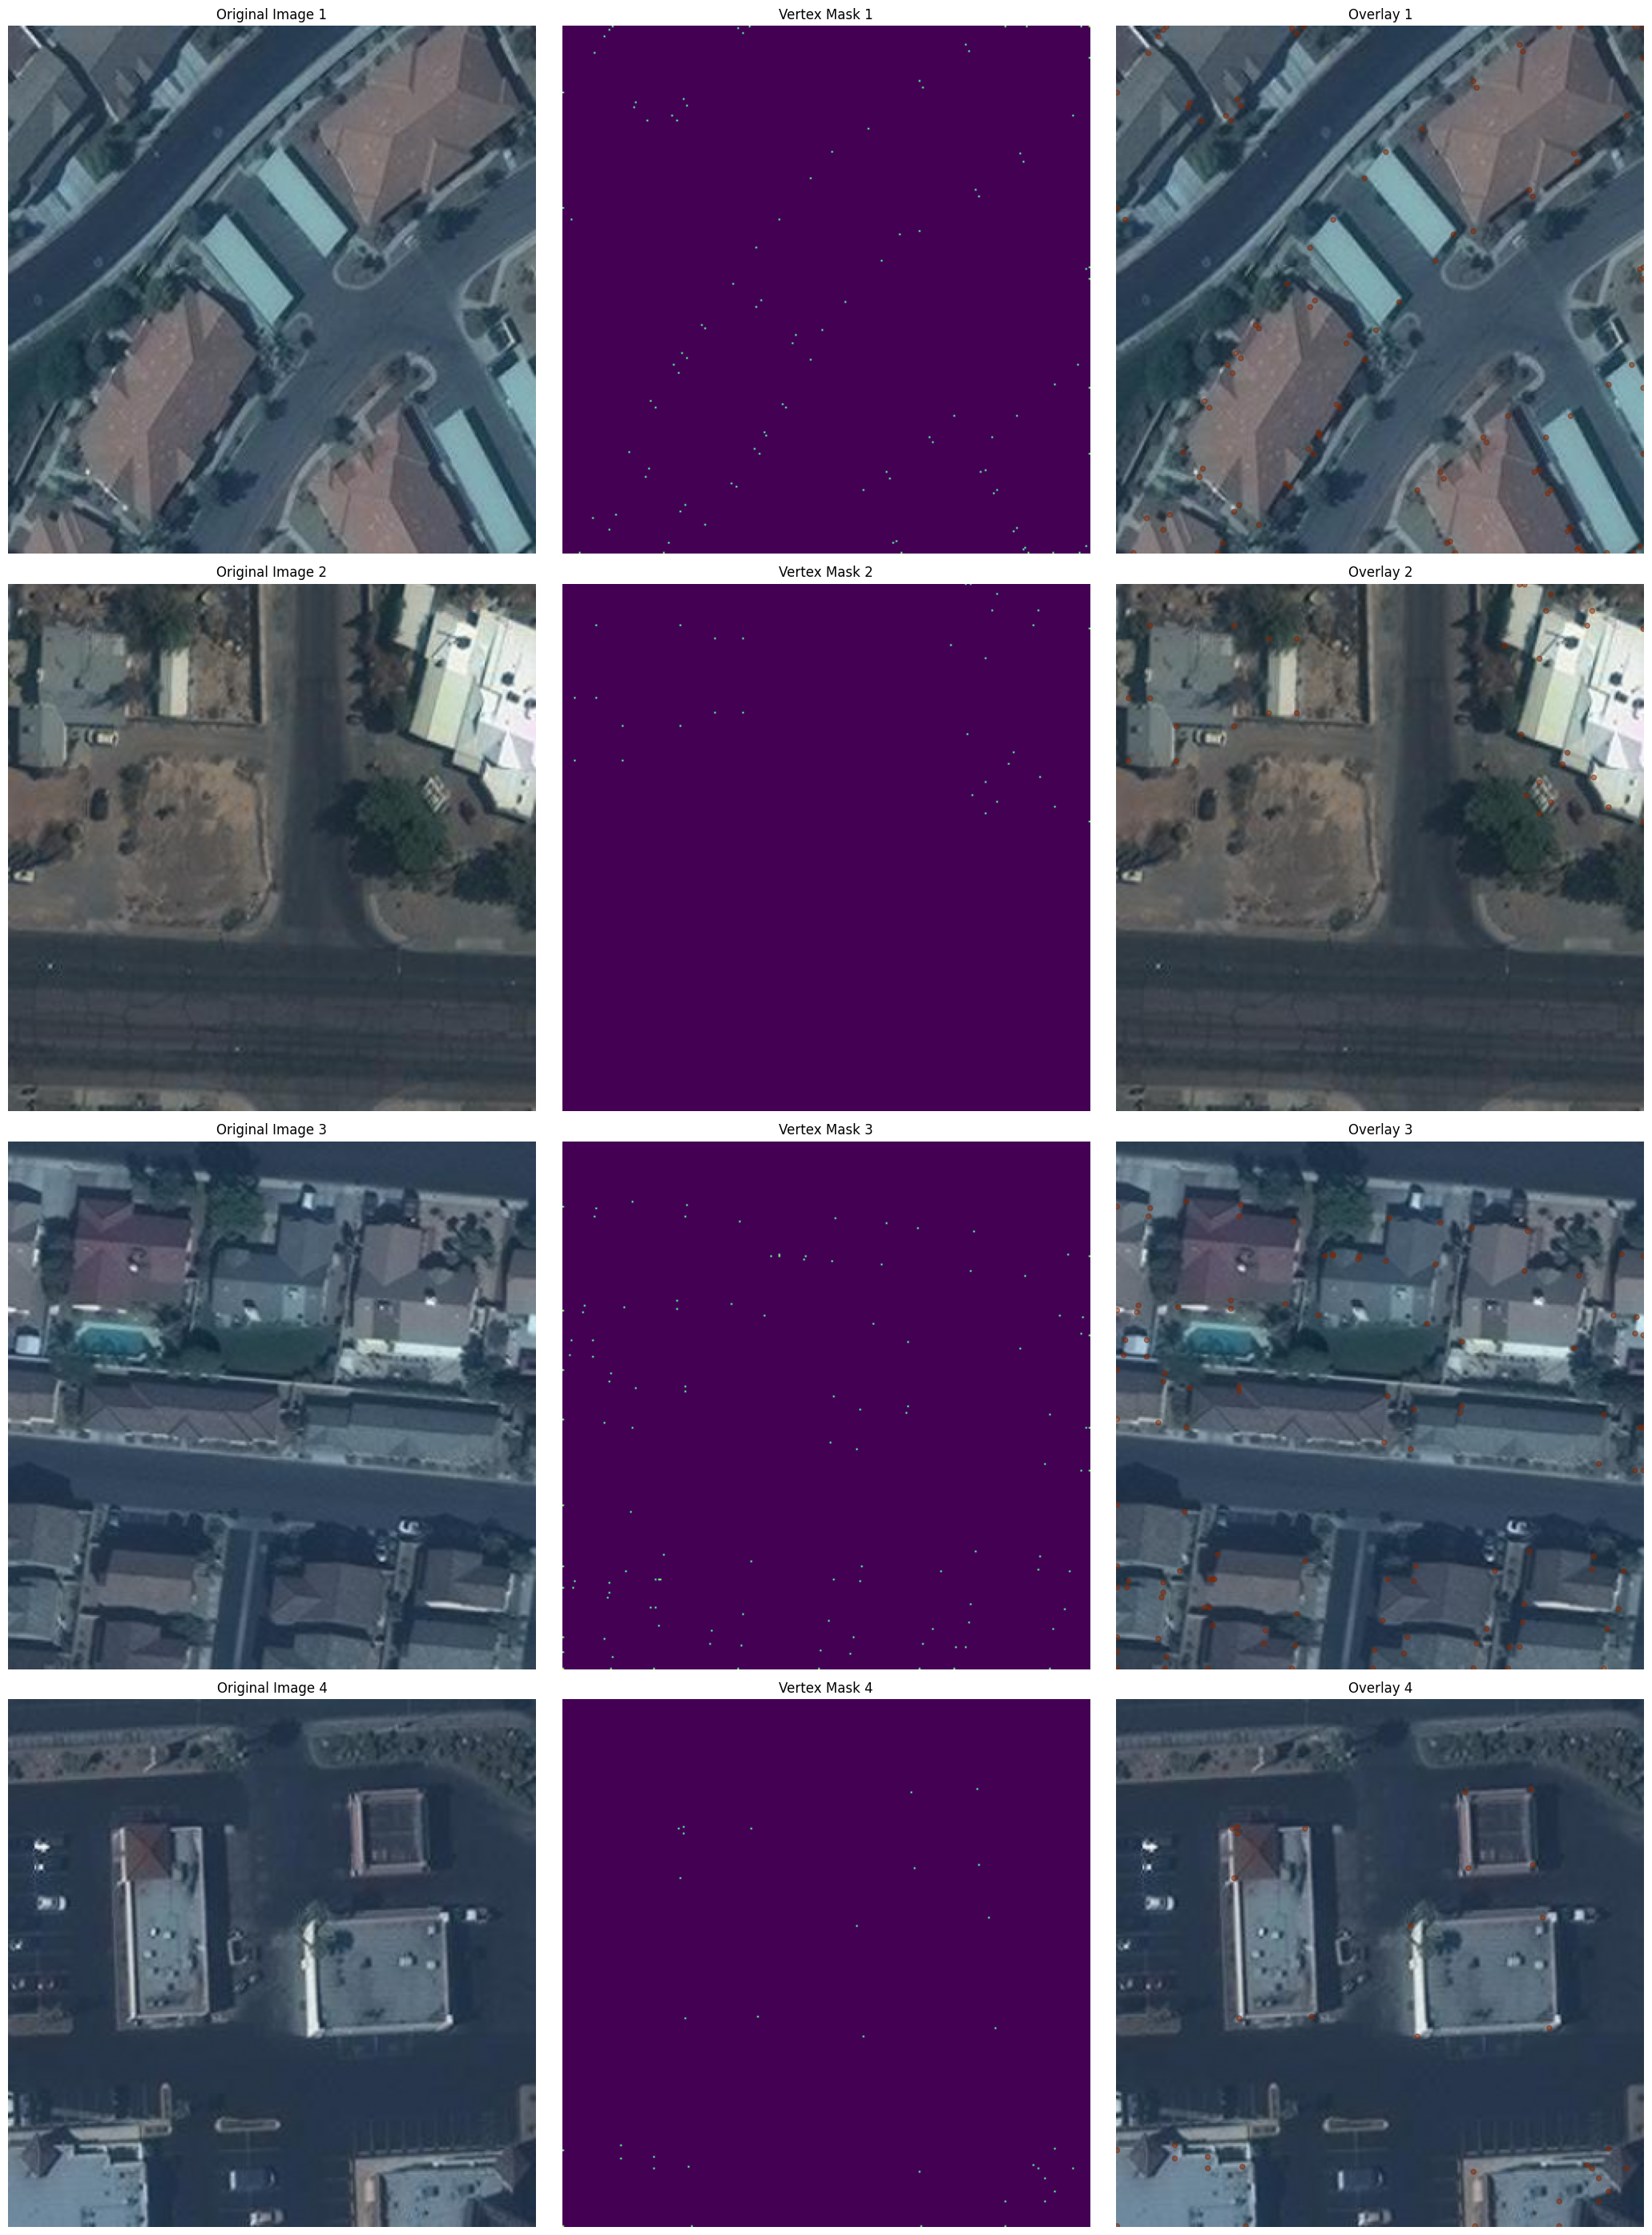

In [7]:
# plot all the images, vertex masks, and scatter plots in the batch
fig, axes = plt.subplots(image.shape[0], 3, figsize=(21, 7*image.shape[0]))

for i in range(image.shape[0]):
    # Original image
    axes[i, 0].imshow(image[i].numpy())
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    # Vertex mask as image
    axes[i, 1].imshow(vertex_mask[i].numpy(), cmap='viridis')
    axes[i, 1].set_title(f'Vertex Mask {i+1}')
    axes[i, 1].axis('off')

    # Scatter plot of vertex mask on original image
    axes[i, 2].imshow(image[i].numpy())
    y, x = np.nonzero(vertex_mask[i].numpy())
    scatter = axes[i, 2].scatter(x, y, c=vertex_mask[i].numpy()[y, x], s=20, alpha=0.5, cmap='Oranges_r')
    axes[i, 2].set_title(f'Overlay {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Network

## Vertex Detection

In [8]:
class DetectionBranch(nn.Module):
    def __init__(self):
        super(DetectionBranch,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1,stride=1,padding=0,bias=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

### Blocks

In [9]:
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x


class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1

### Backbone

In [10]:
class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,t=1):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)
        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        
        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        return d2

### NMS

In [11]:
# This block is not diffrentiable

class NonMaxSuppression(nn.Module):
    def __init__(self, n_peaks=256):
        super(NonMaxSuppression,self).__init__()
        self.k = 3 # kernel
        self.p = 1 # padding
        self.s = 1 # stride
        self.center_idx = self.k**2//2
        self.sigmoid = nn.Sigmoid()
        self.unfold = nn.Unfold(kernel_size=self.k, padding=self.p, stride=self.s)
        self.n_peaks = n_peaks

    def sample_peaks(self, x):
        B, _, H, W = x.shape
        for b in range(B):
            x_b = x[b,0]
            idx = torch.topk(x_b.flatten(), self.n_peaks).indices
            idx_i = torch.div(idx, W, rounding_mode='floor')
            idx_j = idx % W
            idx = torch.cat((idx_i.unsqueeze(1), idx_j.unsqueeze(1)), dim=1)
            idx = idx.unsqueeze(0)

            if b == 0:
                graph = idx
            else:
                graph = torch.cat((graph, idx), dim=0)

        return graph 

    def forward(self, feat):
        B, C, H, W = feat.shape

        x = self.sigmoid(feat)

        # Prepare filter
        f = self.unfold(x).view(B, self.k**2, H, W)
        f = torch.argmax(f, dim=1).unsqueeze(1)
        f = (f == self.center_idx).float()

        # Apply filter
        x = x * f

        # Sample top peaks
        graph = self.sample_peaks(x)
        return x, graph

## GNN

In [12]:
def MultiLayerPerceptron(channels: list, batch_norm=True):
    n_layers = len(channels)

    layers = []
    for i in range(1, n_layers):
        layers.append(nn.Conv1d(channels[i - 1], channels[i], kernel_size=1, bias=True))

        if i < (n_layers - 1):
            if batch_norm:
                layers.append(nn.BatchNorm1d(channels[i]))
            layers.append(nn.ReLU())

    return nn.Sequential(*layers)


class Attention(nn.Module):

    def __init__(self, n_heads: int, d_model: int):
        super().__init__()
        assert d_model % n_heads == 0
        self.dim = d_model // n_heads
        self.n_heads = n_heads
        self.merge = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.proj = nn.ModuleList([deepcopy(self.merge) for _ in range(3)])

    def forward(self, query, key, value):
        b = query.size(0)
        query, key, value = [l(x).view(b, self.dim, self.n_heads, -1)
                             for l, x in zip(self.proj, (query, key, value))]

        b, d, h, n = query.shape
        scores = torch.einsum('bdhn,bdhm->bhnm', query, key) / d**.5
        attn = torch.einsum('bhnm,bdhm->bdhn', torch.nn.functional.softmax(scores, dim=-1), value)

        return self.merge(attn.contiguous().view(b, self.dim*self.n_heads, -1))


class AttentionalPropagation(nn.Module):

    def __init__(self, feature_dim: int, n_heads: int):
        super().__init__()
        self.attn = Attention(n_heads, feature_dim)
        self.mlp = MultiLayerPerceptron([feature_dim*2, feature_dim*2, feature_dim])
        nn.init.constant_(self.mlp[-1].bias, 0.0)

    def forward(self, x):
        message = self.attn(x, x, x)
        return self.mlp(torch.cat([x, message], dim=1))


class AttentionalGNN(nn.Module):

    def __init__(self, feature_dim: int, num_layers: int):
        super().__init__()
        self.conv_init = nn.Sequential(
            nn.Conv1d(feature_dim + 2, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True)
        )

        self.layers = nn.ModuleList([
            AttentionalPropagation(feature_dim, 4)
            for _ in range(num_layers)])

        self.conv_desc = nn.Sequential(
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True)
        )

        self.conv_offset = nn.Sequential(
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, 2, kernel_size=1,stride=1,padding=0,bias=True),
            nn.Hardtanh()
        )

    def forward(self, feat, graph):
        graph = graph.permute(0,2,1)
        feat = torch.cat((feat, graph), dim=1)
        feat = self.conv_init(feat)

        for layer in self.layers:
            feat = feat + layer(feat)

        desc = self.conv_desc(feat)
        offset = self.conv_offset(feat).permute(0,2,1)
        return desc, offset


class ScoreNet(nn.Module):

    def __init__(self, in_ch):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, 256, kernel_size=1, stride=1, padding=0, bias=True)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0, bias=True)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0, bias=True)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        n_points = x.shape[-1]

        x = x.unsqueeze(-1)
        x = x.repeat(1,1,1,n_points)
        t = torch.transpose(x, 2, 3)
        x = torch.cat((x, t), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        return x[:,0]

## Optimal Connection Network

In [13]:
class OptimalMatching(nn.Module):

    def __init__(self):
        super(OptimalMatching, self).__init__()
        
        # Default configuration settings
        self.descriptor_dim = 64
        self.sinkhorn_iterations = 100
        self.attention_layers = 4
        self.correction_radius = 0.05

        # Modules
        self.scorenet1 = ScoreNet(self.descriptor_dim * 2)
        self.scorenet2 = ScoreNet(self.descriptor_dim * 2)
        self.gnn = AttentionalGNN(self.descriptor_dim, self.attention_layers)
            

    def normalize_coordinates(self, graph, ws, input):
        if input == 'global':
            graph = (graph * 2 / ws - 1)
        elif input == 'normalized':
            graph = ((graph + 1) * ws / 2)
            graph = torch.round(graph).long()
            graph[graph < 0] = 0
            graph[graph >= ws] = ws - 1
        return graph


    def predict(self, image, descriptors, graph):
        B, _, H, W = image.shape
        B, N, _ = graph.shape

        for b in range(B):
            b_desc = descriptors[b]
            b_graph = graph[b]

            # Extract descriptors
            b_desc = b_desc[:, b_graph[:,0], b_graph[:,1]]

            # Concatenate descriptors in batches
            if b == 0:                    
                sel_desc = b_desc.unsqueeze(0)
            else:
                sel_desc = torch.cat((sel_desc, b_desc.unsqueeze(0)), dim=0)

        # Multi-layer Transformer network.
        norm_graph = self.normalize_coordinates(graph, W, input="global") #out: normalized coordinate system [-1, 1]
        sel_desc, offset = self.gnn(sel_desc, norm_graph)

        # Correct points coordinates
        norm_graph = norm_graph + offset * self.correction_radius
        graph = self.normalize_coordinates(norm_graph, W, input="normalized") # out: global coordinate system [0, W]

        # Compute scores
        scores_1 = self.scorenet1(sel_desc)
        scores_2 = self.scorenet2(sel_desc)
        scores = scores_1 + torch.transpose(scores_2, 1, 2)

        scores = scores_to_permutations(scores)
        poly = permutations_to_polygons(scores, graph, out='coco') 

        return poly

# Training

### Loss Function

In [ ]:
class SegmentationLoss(nn.Module):
    def __init__(self):
        super(SegmentationLoss, self).__init__()
    
    def forward(self, polygon_masks, ground_truth_mask):
        """
        Args:
        polygon_masks (torch.Tensor): Tensor of shape (K, H, W) containing K polygon masks
        ground_truth_mask (torch.Tensor): Tensor of shape (H, W) containing the ground truth segmentation mask
        
        Returns:
        torch.Tensor: The computed segmentation loss
        """
        # Sum all polygon masks
        combined_masks = torch.sum(polygon_masks, dim=0)
        
        # Compute soft Intersection over Union
        intersection = torch.min(combined_masks, ground_truth_mask)
        union = torch.max(combined_masks, ground_truth_mask)
        
        iou = torch.sum(intersection) / torch.sum(union)
        
        # The loss is 1 - IoU to minimize
        loss = 1 - iou
        
        return loss

# Example usage
# Assuming we have 3 polygon masks of size 64x64
# polygon_masks = torch.rand(3, 64, 64)
# ground_truth_mask = torch.rand(64, 64)

# criterion = SegmentationLoss()
# loss = criterion(polygon_masks, ground_truth_mask)
# print(f"Segmentation Loss: {loss.item()}")

In [ ]:
class AngleLoss(nn.Module):
    def __init__(self, sigma=1.0):
        super(AngleLoss, self).__init__()
        self.sigma = sigma

    def calculate_angles(self, polygons):
        # polygons shape: (batch_size, num_polygons, num_vertices, 2)
        v1 = polygons - torch.roll(polygons, shifts=1, dims=2)
        v2 = torch.roll(polygons, shifts=-1, dims=2) - polygons
        
        dot_product = torch.sum(v1 * v2, dim=-1)
        v1_norm = torch.norm(v1, dim=-1)
        v2_norm = torch.norm(v2, dim=-1)
        
        cos_angles = dot_product / (v1_norm * v2_norm + 1e-8)
        angles = torch.acos(torch.clamp(cos_angles, -1.0 + 1e-8, 1.0 - 1e-8))
        return angles

    def forward(self, pred_polygons, gt_polygons):
        # pred_polygons and gt_polygons shape: (batch_size, num_polygons, num_vertices, 2)
        pred_angles = self.calculate_angles(pred_polygons)
        gt_angles = self.calculate_angles(gt_polygons)
        
        delta_k = torch.abs(pred_angles - gt_angles)
        loss = 1 - torch.exp(-self.sigma * delta_k)
        
        # Sum over vertices and polygons, mean over batch
        return loss.sum(dim=(1, 2)).mean()

# # Example usage:
# if __name__ == "__main__":
#     # Create some example batched data
#     batch_size = 2
#     num_polygons = 3
#     num_vertices = 4
    
#     pred_polygons = torch.rand(batch_size, num_polygons, num_vertices, 2)
#     gt_polygons = torch.rand(batch_size, num_polygons, num_vertices, 2)

#     # Instantiate the loss module
#     angle_loss = AngleLoss(sigma=1.0)

#     # Calculate the loss
#     loss = angle_loss(pred_polygons, gt_polygons)
#     print(f"Angle Loss: {loss.item()}")

In [14]:
w = 100
# criterion = nn.BCELoss(weight=torch.tensor([w]))
detection_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([w])).to(device)
# matching_loss = nn.NLLLoss().to(device)
# segmentation_loss = SegmentationLoss().to(device)
# angle_loss = AngleLoss().to(device)

In [15]:
# Backbone
model = R2U_Net()
model = model.cuda()
model = model.train()

# Vertex Detection
head_ver = DetectionBranch()
head_ver = head_ver.cuda()
head_ver = head_ver.train()

# NMS
suppression = NonMaxSuppression()
suppression = suppression.cuda()

# Matching
# matching = OptimalMatching()
# matching = matching.cuda()
# matching = matching.train()

In [16]:
# Optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': head_ver.parameters()},
    # {'params': matching.parameters()}
], lr=1e-4)

In [17]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

In [18]:
# Training Loop
for epoch in range(100):
    for image, vertex_mask, seg_mask, permutation_matrix in tqdm(dataloader):
        image = image.float().cuda().permute(0, 3, 1, 2)
        vertex_mask = vertex_mask.unsqueeze(1).cuda()
        # seg_mask = seg_mask.unsqueeze(1).cuda()
        # permutation_matrix = permutation_matrix.cuda()

        optimizer.zero_grad()

        # Forward pass
        features = model(image)
        vertex_logits = head_ver(features) # occupancy grid
        _ , graph = suppression(vertex_logits)
        # poly = matching.predict(image, features, graph)
        # Compute loss
        loss = detection_loss(vertex_logits.to(device), vertex_mask.float().to(device))

        # Backward pass
        loss.backward()
        optimizer.step()


        # del image, vertex_mask, seg_mask, permutation_matrix, features, vertex_logits, graph, poly

    print(f"Epoch {epoch} - Loss: {loss.item()}")

100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Epoch 0 - Loss: 0.5132817029953003


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


Epoch 1 - Loss: 0.47607672214508057


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Epoch 2 - Loss: 0.43709197640419006


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Epoch 3 - Loss: 0.32164931297302246


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


Epoch 4 - Loss: 0.41465485095977783


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Epoch 5 - Loss: 0.30537018179893494


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch 6 - Loss: 0.3040103614330292


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch 7 - Loss: 0.22707922756671906


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch 8 - Loss: 0.30721595883369446


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Epoch 9 - Loss: 0.2381288707256317


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


Epoch 10 - Loss: 0.2886843681335449


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]


Epoch 11 - Loss: 0.26675090193748474


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


Epoch 12 - Loss: 0.24871216714382172


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


Epoch 13 - Loss: 0.28970056772232056


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Epoch 14 - Loss: 0.26810222864151


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


Epoch 15 - Loss: 0.19121715426445007


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


Epoch 16 - Loss: 0.19138485193252563


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


Epoch 17 - Loss: 0.2549624443054199


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


Epoch 18 - Loss: 0.20874425768852234


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Epoch 19 - Loss: 0.20961910486221313


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]


Epoch 20 - Loss: 0.1763758361339569


 16%|█▌        | 8/50 [00:03<00:17,  2.42it/s]


KeyboardInterrupt: 

### Inference

In [19]:
image, vertex_mask, seg_mask, permutation_matrix = next(iter(dataloader))
image = image.float().cuda().permute(0, 3, 1, 2)

In [20]:
features = model(image)
vertex_logits = head_ver(features)
_ , graph = suppression(vertex_logits)

In [21]:
features.shape

torch.Size([2, 64, 320, 320])

In [22]:
vertex_logits.shape

torch.Size([2, 1, 320, 320])

In [23]:
graph.shape

torch.Size([2, 256, 2])

In [26]:
mask = np.zeros((320, 320), dtype=np.uint8)
for i in range(graph.shape[1]):
    mask[graph[0, i, 0], graph[0, i, 1]] = 1

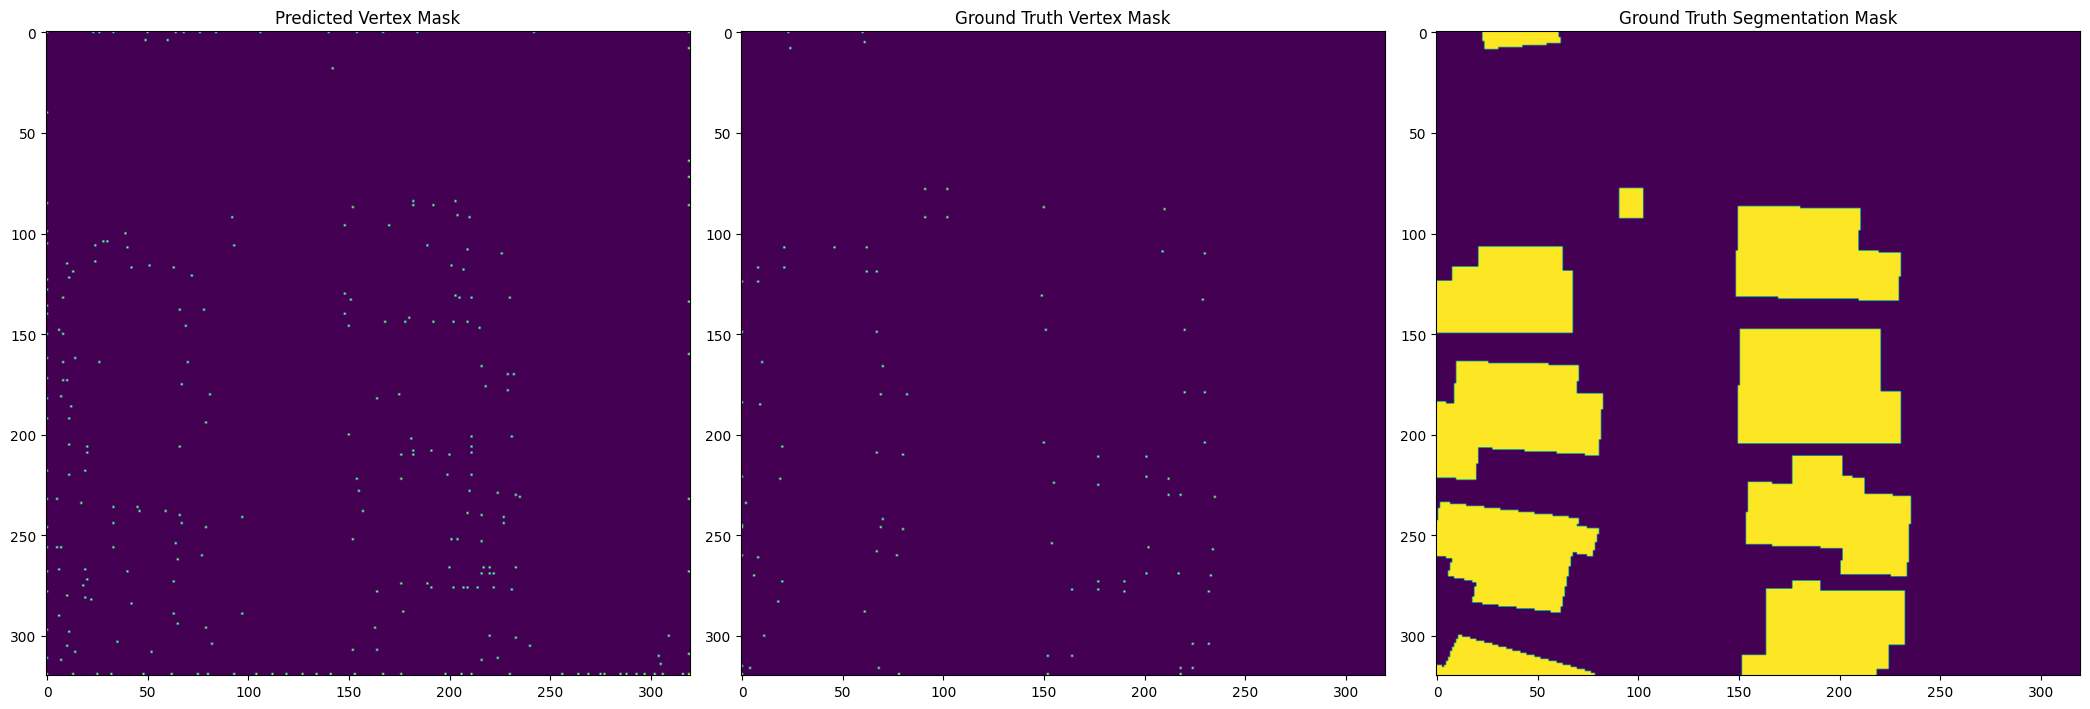

In [52]:
# plot mask and seg mask
fig, axes = plt.subplots(1, 3, figsize=(21, 13))
axes[0].imshow(mask)
axes[1].imshow(vertex_mask[0].cpu().numpy().squeeze())
axes[2].imshow(seg_mask[0].cpu().numpy().squeeze())

axes[0].set_title('Predicted Vertex Mask')
axes[1].set_title('Ground Truth Vertex Mask')
axes[2].set_title('Ground Truth Segmentation Mask')

plt.tight_layout()
plt.show()

In [42]:
# apply sigmoid to the logits
output = torch.sigmoid(vertex_logits)
output.shape

torch.Size([2, 1, 320, 320])

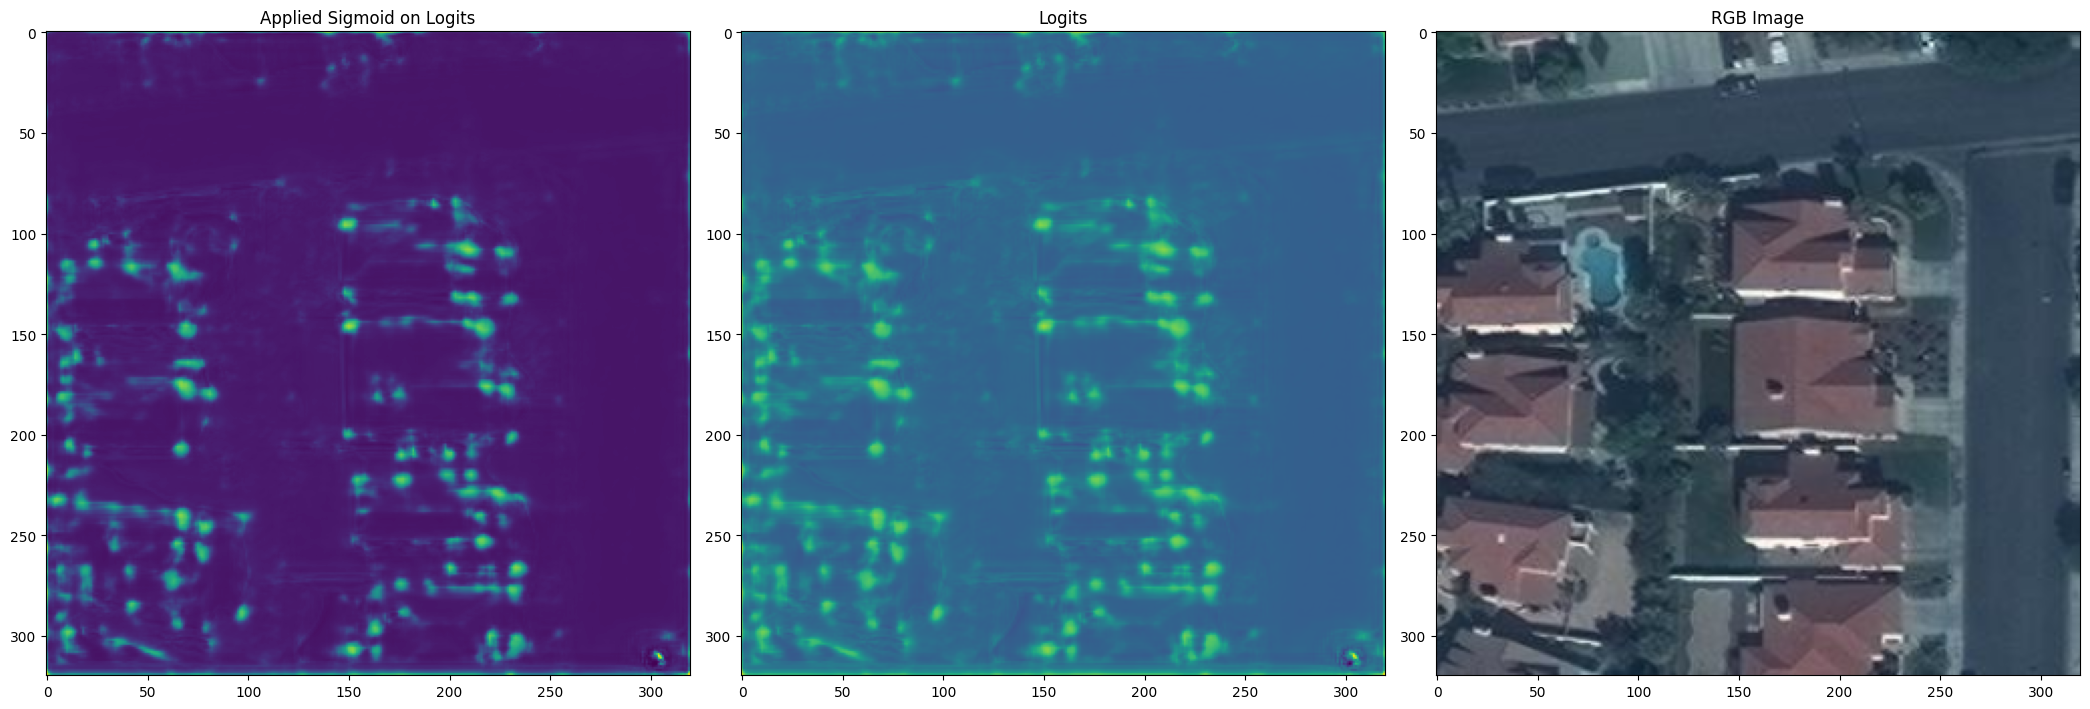

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(21, 13))
axes[0].imshow(output[0].detach().cpu().numpy().squeeze())
axes[1].imshow(vertex_logits[0].detach().cpu().numpy().squeeze())
axes[2].imshow(image[0].cpu().numpy().squeeze().transpose(1, 2, 0))

axes[0].set_title('Applied Sigmoid on Logits')
axes[1].set_title('Logits')
axes[2].set_title('RGB Image')

plt.tight_layout()
plt.show()

# Prediction

In [ ]:
def bounding_box_from_points(points):
    points = np.array(points).flatten()
    even_locations = np.arange(points.shape[0]/2) * 2
    odd_locations = even_locations + 1
    X = np.take(points, even_locations.tolist())
    Y = np.take(points, odd_locations.tolist())
    bbox = [X.min(), Y.min(), X.max()-X.min(), Y.max()-Y.min()]
    bbox = [int(b) for b in bbox]
    return bbox


def single_annotation(image_id, poly):
    _result = {}
    _result["image_id"] = int(image_id)
    _result["category_id"] = 100 
    _result["score"] = 1
    _result["segmentation"] = poly
    _result["bbox"] = bounding_box_from_points(_result["segmentation"])
    return _result

In [ ]:
def prediction(batch_size, images_directory, annotations_path):

    # Vertex Detection
    model = R2U_Net()
    model = model.cuda()
    model = model.train()

    head_ver = DetectionBranch()
    head_ver = head_ver.cuda()
    head_ver = head_ver.train()


    # NMS
    suppression = NonMaxSuppression()
    suppression = suppression.cuda()

    # Generate the connections between virtices
    matching = OptimalMatching()
    matching = matching.cuda()
    matching = matching.train()

    # NOTE: The modules are set to .train() mode during inference to make sure that the BatchNorm layers 
    # rely on batch statistics rather than the mean and variance estimated during training. 
    # Experimentally, using batch stats makes the network perform better during inference.

    print("Loading pretrained model")
    model.load_state_dict(torch.load("./trained_weights/polyworld_backbone"))
    head_ver.load_state_dict(torch.load("./trained_weights/polyworld_seg_head"))
    matching.load_state_dict(torch.load("./trained_weights/polyworld_matching"))

    # Initiate the dataloader
    CrowdAI_dataset = CrowdAI(images_directory=images_directory, annotations_path=annotations_path)
    dataloader = DataLoader(CrowdAI_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

    train_iterator = tqdm(dataloader)

    speed = []
    predictions = []
    for i_batch, sample_batched in enumerate(train_iterator):

        rgb = sample_batched['image'].cuda().float()
        idx = sample_batched['image_idx']

        t0 = time.time()

        features = model(rgb)
        occupancy_grid = head_ver(features)

        _, graph_pressed = suppression(occupancy_grid)

        poly = matching.predict(rgb, features, graph_pressed) 

        speed.append(time.time() - t0)


        for i, pp in enumerate(poly):
            for p in pp:
                predictions.append(single_annotation(idx[i], [p]))

        del features
        del occupancy_grid
        del graph_pressed
        del poly
        del rgb
        del idx

    print("Average model speed: ", np.mean(speed) / batch_size, " [s / image]")

    # fp = open("predictions.json", "w")
    # fp.write(json.dumps(predictions))
    # fp.close()

In [ ]:
prediction(batch_size=1, images_directory="data/val/images/", annotations_path="data/val/annotation.json")

# Playground

In [ ]:
with open('data/val/annotation.json') as f:
    annotations = json.load(f)

images = pd.DataFrame(annotations['images'])
labels = pd.DataFrame(annotations['annotations'])

In [ ]:
segmentations = labels[labels['image_id'] == 9]

In [ ]:
segmentations = segmentations['segmentation'].values
segmentations = [e[0] for e in segmentations]
segmentations = [np.array(poly, dtype=int).reshape(-1, 2) for poly in segmentations]
# segmentations = [np.array(poly * ratio, dtype=int).reshape(-1, 2) for poly in segmentations]
segmentations

In [ ]:

N = 256
permutation_matrix = np.zeros((N, N))

n = 0
for i, polygon in enumerate(segmentations):
    for v, point in enumerate(polygon):
        if v != len(polygon) - 1:
            permutation_matrix[n, n+1] = 1
        else:
            permutation_matrix[n, n-v] = 1
        n += 1
    
    print(f'Polygon {i} Finished')

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(permutation_matrix)

In [ ]:
len(segmentations)

In [ ]:
def create_adjacency_matrix(polygons, N=256):
    # Initialize the permutation matrix
    permutation_matrix = np.zeros((N, N), dtype=int)
    
    for polygon in polygons:
        # Extract vertices from the polygon list
        vertices = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
        
        # Get the number of vertices
        num_vertices = len(vertices)
        
        for i in range(num_vertices):
            # Current vertex
            current_vertex = vertices[i]
            # Next vertex (with wrap-around)
            next_vertex = vertices[(i + 1) % num_vertices]
            
            # Find indices of current and next vertices
            current_index = i
            next_index = (i + 1) % num_vertices
            
            # Update the permutation matrix
            permutation_matrix[current_index, next_index] = 1
            # permutation_matrix[next_index, current_index] = 1
    
    return permutation_matrix

In [ ]:
adj_matrix = create_adjacency_matrix(segmentations, N=256)

In [ ]:
adj_matrix.shape

In [ ]:
adj_matrix

In [ ]:
plt.imshow(adj_matrix[:20, :20])